In [165]:
import gymnasium as gym
help(gym.make)

Help on function make in module gymnasium.envs.registration:

make(id: 'str | EnvSpec', max_episode_steps: 'int | None' = None, disable_env_checker: 'bool | None' = None, **kwargs: 'Any') -> 'Env'
    Creates an environment previously registered with :meth:`gymnasium.register` or a :class:`EnvSpec`.
    
    To find all available environments use ``gymnasium.envs.registry.keys()`` for all valid ids.
    
    Args:
        id: A string for the environment id or a :class:`EnvSpec`. Optionally if using a string, a module to import can be included, e.g. ``'module:Env-v0'``.
            This is equivalent to importing the module first to register the environment followed by making the environment.
        max_episode_steps: Maximum length of an episode, can override the registered :class:`EnvSpec` ``max_episode_steps``
            with the value being passed to :class:`gymnasium.wrappers.TimeLimit`.
            Using ``max_episode_steps=-1`` will not apply the wrapper to the environment.
  

In [166]:
env = gym.make("CartPole-v1", render_mode="human")  
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [167]:
print(env.observation_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [168]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F 



class Qnetwork(nn.Module):
    def __init__(self,state_size,action_size):
        super(Qnetwork,self).__init__()

        self.fc1=nn.Linear(state_size,128)
        self.fc2=nn.Linear(128,128)
        self.fc3=nn.Linear(128,action_size)

    def forward(self,state):

        x=torch.relu(self.fc1(torch.tensor(state)))
        x=torch.relu(self.fc2(x))
        return self.fc3(x)

target_network=Qnetwork(4,2)
online_network=Qnetwork(4,2)

In [169]:
import math
import random

class Pendulo:
    def __init__(self,env):
        self.env= env
    
    def get_action(self,q_values,step,start,end,decay):
        epsilon=(end+(start-end)*math.exp(-step/decay))
        sample=random.randint(0,2)
        if sample<epsilon:
            return random.choice(range(len(q_values)))
    
        return torch.argmax(q_values).item()
    

    def reset(self):
        self.env.reset()
     



In [170]:
from collections import deque
import numpy as np
import torch

class ReplayBuffer:

    def __init__(self,capacity):

        self.memory=deque(maxlen=capacity)
    
    def push(self,state,action,reward,next_state,done):

        experience_tuple=(state,action,reward,next_state,done)
        self.memory.append(experience_tuple)

    def __len__(self):
        return  len(self.memory)
    
    def sample(self,batch_size):

        batch=random.sample(self.memory,batch_size)

        states,actions,rewards,next_states,dones=zip(*batch)
        
        states=torch.tensor(states,dtype=torch.float32)
        actions=torch.tensor(actions,dtype=torch.long).unsqueeze(1)
        rewards=torch.tensor(rewards,dtype=torch.float32)
        next_states=torch.tensor(next_states,dtype=torch.float32)
        dones=torch.tensor(dones,dtype=torch.float32)

        return(states,actions,rewards,next_states,dones)
    

In [171]:
def update_target_network(target_network,online_network,tau):
    target_net_state_dict=target_network.state_dict()
    online_net_state_dict=online_network.state_dict()

    for key in online_net_state_dict:
        target_net_state_dict[key]=(online_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau))

        target_network.load_state_dict(target_net_state_dict)
        
    return done



In [172]:
def set_seed(env, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

In [173]:
replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=5e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


In [174]:

reward_lis=[]
for episode in range(2000):

    state,info=env.reset()
    done=False
    step=0
    episode_reward=0

    while not done:
        step+=1
        q_values=online_network(state)
        action=pendulo.get_action(q_values,step,start=0.9,end=0.05,decay=1000)
        next_state,reward,terminate,truncated,_=env.step(action)
        done=terminate or truncated
        replay_buffer.push(state,action,reward,next_state,done)

        if len(replay_buffer)>=batch_size:

            states,actions,rewards,nex_states,dones=replay_buffer.sample(64)
            q_values=online_network(states).gather(1,actions).squeeze(1)
            with torch.no_grad():
                next_actions=online_network(nex_states).argmax(1).unsqueeze(1)
                next_q_values=target_network(nex_states).gather(1,next_actions).squeeze(1)
                target_q_values=rewards+gamma*next_q_values*(1-dones)

            loss=F.mse_loss(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            update_target_network(target_network,online_network,tau)
        
        state=next_state
        episode_reward+=reward
    reward_lis.append(episode_reward)
    
    print(f"Episode: {episode}, Step: {step}, Reward: {reward}, Total Reward: {episode_reward}")

    

Episode: 0, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 1, Step: 15, Reward: 1.0, Total Reward: 15.0
Episode: 2, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 3, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 4, Step: 11, Reward: 1.0, Total Reward: 11.0


C:\Users\edgar\AppData\Local\Temp\ipykernel_17820\997204895.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.relu(self.fc1(torch.tensor(state)))


Episode: 5, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 6, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 7, Step: 16, Reward: 1.0, Total Reward: 16.0
Episode: 8, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 9, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 10, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 11, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 12, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 13, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 14, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 15, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 16, Step: 12, Reward: 1.0, Total Reward: 12.0
Episode: 17, Step: 13, Reward: 1.0, Total Reward: 13.0
Episode: 18, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 19, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 20, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 21, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 22, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 23, Step: 20, 

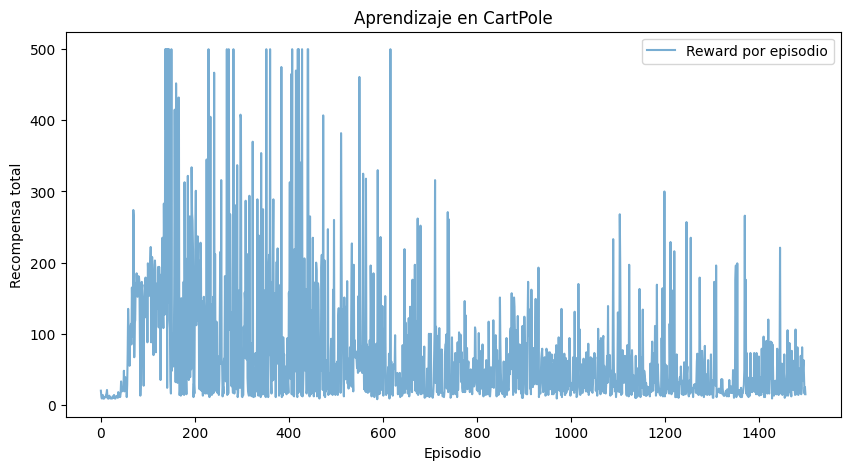

In [ ]:

import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(10000)
tau=0.01
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-4)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

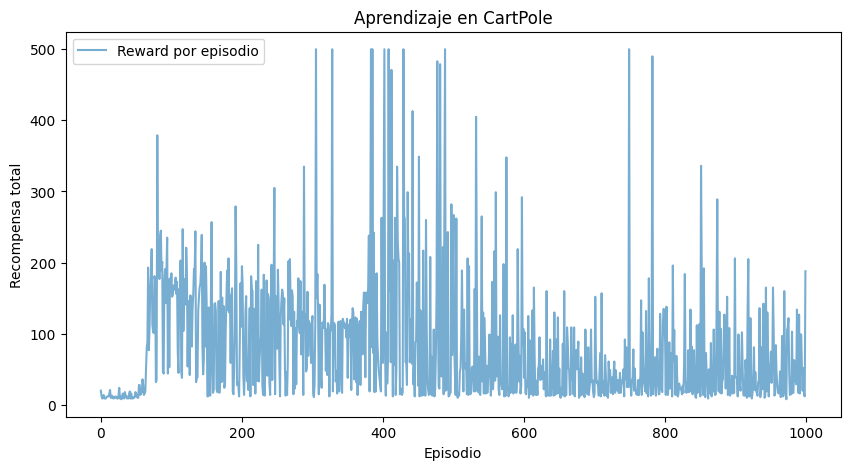

In [ ]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-4)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

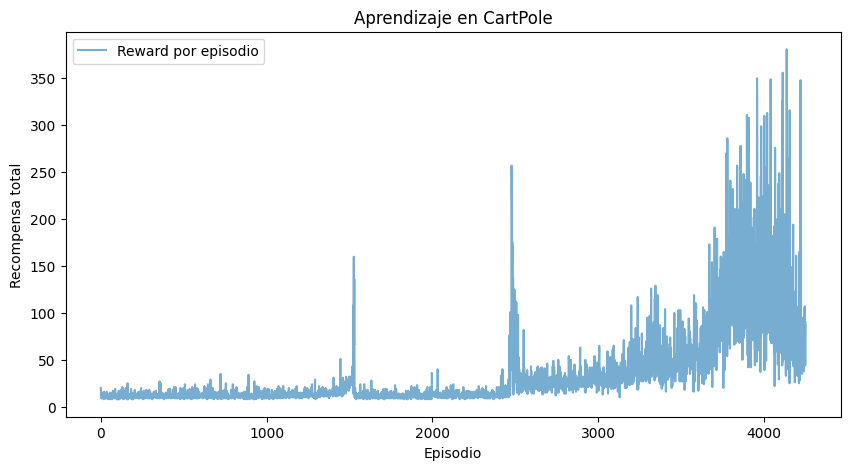

'\nneuronas de 64\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=1e-5)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n\n'

In [153]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()


"""
neuronas de 64
replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

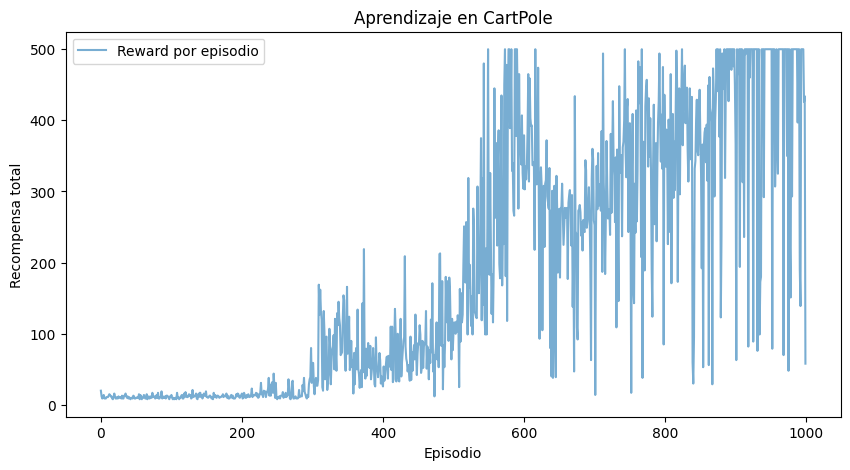

'\n\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=5e-5)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n\n'

In [127]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()


"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=5e-5)
pendulo=Pendulo(env)
set_seed(env, seed=42)


"""

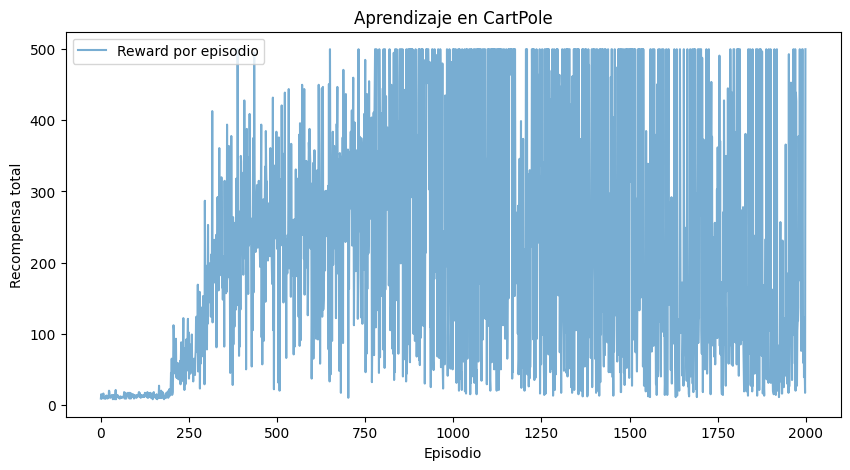

'\n\nreplay_buffer=ReplayBuffer(50000)\ntau=0.005\ngamma=0.99\nbatch_size=64\noptimizer=optim.Adam(online_network.parameters(),lr=1e-4)\npendulo=Pendulo(env)\nset_seed(env, seed=42)\n\n'

In [175]:
import matplotlib.pyplot as plt

#Promedio móvil (rolling mean)
#window = 100
#moving_avg = np.convolve(reward_lis, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(reward_lis, label="Reward por episodio", alpha=0.6)
#plt.plot(range(window-1, len(reward_lis)), moving_avg, label=f"Promedio móvil {window}", linewidth=2, color="red")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()



"""

replay_buffer=ReplayBuffer(50000)
tau=0.005
gamma=0.99
batch_size=64
optimizer=optim.Adam(online_network.parameters(),lr=1e-4)
pendulo=Pendulo(env)
set_seed(env, seed=42)

"""

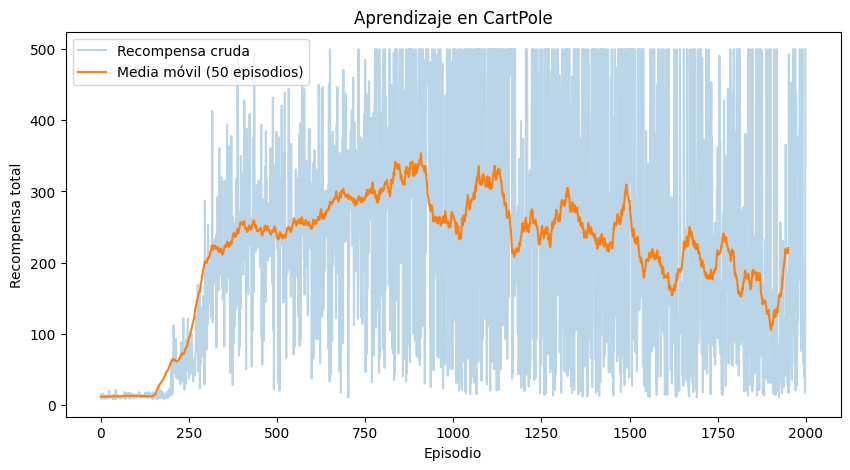

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_lis, alpha=0.3, label="Recompensa cruda")
plt.plot(moving_average(reward_lis, 50), label="Media móvil (50 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()

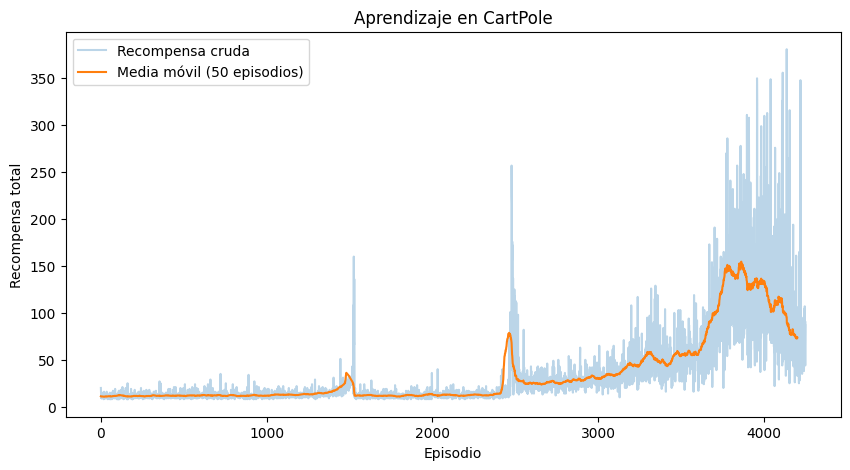

In [154]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_lis, alpha=0.3, label="Recompensa cruda")
plt.plot(moving_average(reward_lis, 50), label="Media móvil (50 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()

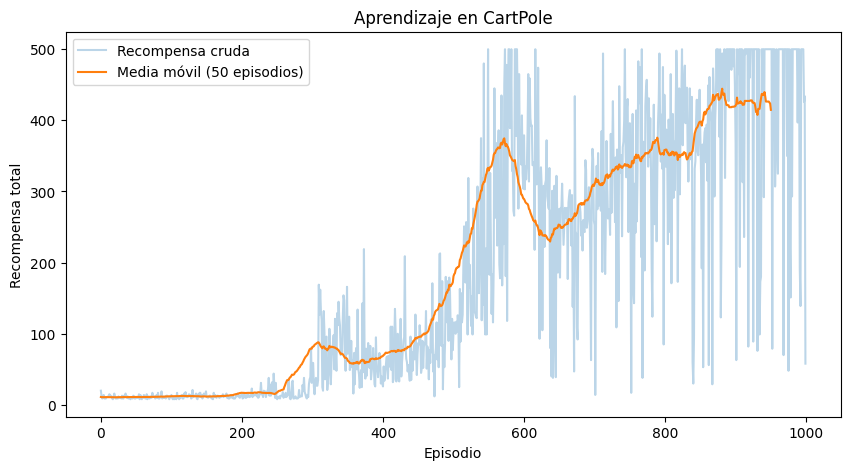

In [131]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_lis, alpha=0.3, label="Recompensa cruda")
plt.plot(moving_average(reward_lis, 50), label="Media móvil (50 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Aprendizaje en CartPole")
plt.legend()
plt.show()

In [19]:
# 7. Guardar modelo + optimizador + buffer + episodio
import pickle
checkpoint = {
    "online_network": online_network.state_dict(),
    "target_network": target_network.state_dict(),
    "optimizer": optimizer.state_dict(),
    "episode": episode
}
torch.save(checkpoint, "ddqn_cartpole.pth")

with open("replay_buffer.pkl", "wb") as f:
    pickle.dump(replay_buffer, f)

print(" Modelo y buffer guardados")

 Modelo y buffer guardados


In [20]:
# Cargar checkpoint
checkpoint = torch.load("ddqn_cartpole.pth", map_location=torch.device("cpu"))
online_network.load_state_dict(checkpoint["online_network"])
target_network.load_state_dict(checkpoint["target_network"])
optimizer.load_state_dict(checkpoint["optimizer"])
start_episode = checkpoint["episode"] + 1

# Cargar buffer
with open("replay_buffer.pkl", "rb") as f:
    replay_buffer = pickle.load(f)

print(f" Modelo cargado. Continuando desde episodio {start_episode}")

 Modelo cargado. Continuando desde episodio 1000


C:\Users\edgar\AppData\Local\Temp\ipykernel_17820\1600634224.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("ddqn_cartpole.pth", map_location=to

In [21]:
for episode in range(start_episode,start_episode+1000):

    state,info=env.reset()
    done=False
    step=0
    episode_reward=0

    while not done:
        step+=1
        q_values=online_network(state)
        action=pendulo.get_action(q_values,step,start=0.9,end=0.05,decay=1000)
        next_state,reward,terminate,truncated,_=env.step(action)
        done=terminate or truncated
        replay_buffer.push(state,action,reward,next_state,done)

        if len(replay_buffer)>=batch_size:

            states,actions,rewards,nex_states,dones=replay_buffer.sample(64)
            q_values=online_network(states).gather(1,actions).squeeze(1)
            with torch.no_grad():
                next_actions=online_network(nex_states).argmax(1).unsqueeze(1)
                next_q_values=target_network(nex_states).gather(1,next_actions).squeeze(1)
                target_q_values=rewards+gamma*next_q_values*(1-dones)

            loss=F.mse_loss(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            update_target_network(target_network,online_network,tau)
        
        state=next_state
        episode_reward+=reward
    
        print(f"Episode: {episode}, Step: {step}, Reward: {reward}, Total Reward: {episode_reward}")

C:\Users\edgar\AppData\Local\Temp\ipykernel_17820\997204895.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.relu(self.fc1(torch.tensor(state)))


Episode: 1000, Step: 1, Reward: 1.0, Total Reward: 1.0
Episode: 1000, Step: 2, Reward: 1.0, Total Reward: 2.0
Episode: 1000, Step: 3, Reward: 1.0, Total Reward: 3.0
Episode: 1000, Step: 4, Reward: 1.0, Total Reward: 4.0
Episode: 1000, Step: 5, Reward: 1.0, Total Reward: 5.0
Episode: 1000, Step: 6, Reward: 1.0, Total Reward: 6.0
Episode: 1000, Step: 7, Reward: 1.0, Total Reward: 7.0
Episode: 1000, Step: 8, Reward: 1.0, Total Reward: 8.0
Episode: 1000, Step: 9, Reward: 1.0, Total Reward: 9.0
Episode: 1000, Step: 10, Reward: 1.0, Total Reward: 10.0
Episode: 1000, Step: 11, Reward: 1.0, Total Reward: 11.0
Episode: 1000, Step: 12, Reward: 1.0, Total Reward: 12.0
Episode: 1001, Step: 1, Reward: 1.0, Total Reward: 1.0
Episode: 1001, Step: 2, Reward: 1.0, Total Reward: 2.0
Episode: 1001, Step: 3, Reward: 1.0, Total Reward: 3.0
Episode: 1001, Step: 4, Reward: 1.0, Total Reward: 4.0
Episode: 1001, Step: 5, Reward: 1.0, Total Reward: 5.0
Episode: 1001, Step: 6, Reward: 1.0, Total Reward: 6.0
Epis